<a href="https://www.kaggle.com/code/wonduk/data-analysis-on-pokemon-data-is-or-not-legend?scriptVersionId=98382603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Legendary Pokemon
## 1.data exploring with visualization

first, import some useful modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# to visualize missing values
import missingno as msno
# to draw plot in notebook
%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

# for spliting train data andd test data
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error

read the data

In [2]:
pokemon_data = pd.read_csv("../input/pokemon/pokemon_alopez247.csv")
pd.set_option('display.max_columns',None)

In [3]:
pokemon = pd.DataFrame(pokemon_data)
pokemon.head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


In [4]:
pokemon.shape

(721, 23)

<AxesSubplot:>

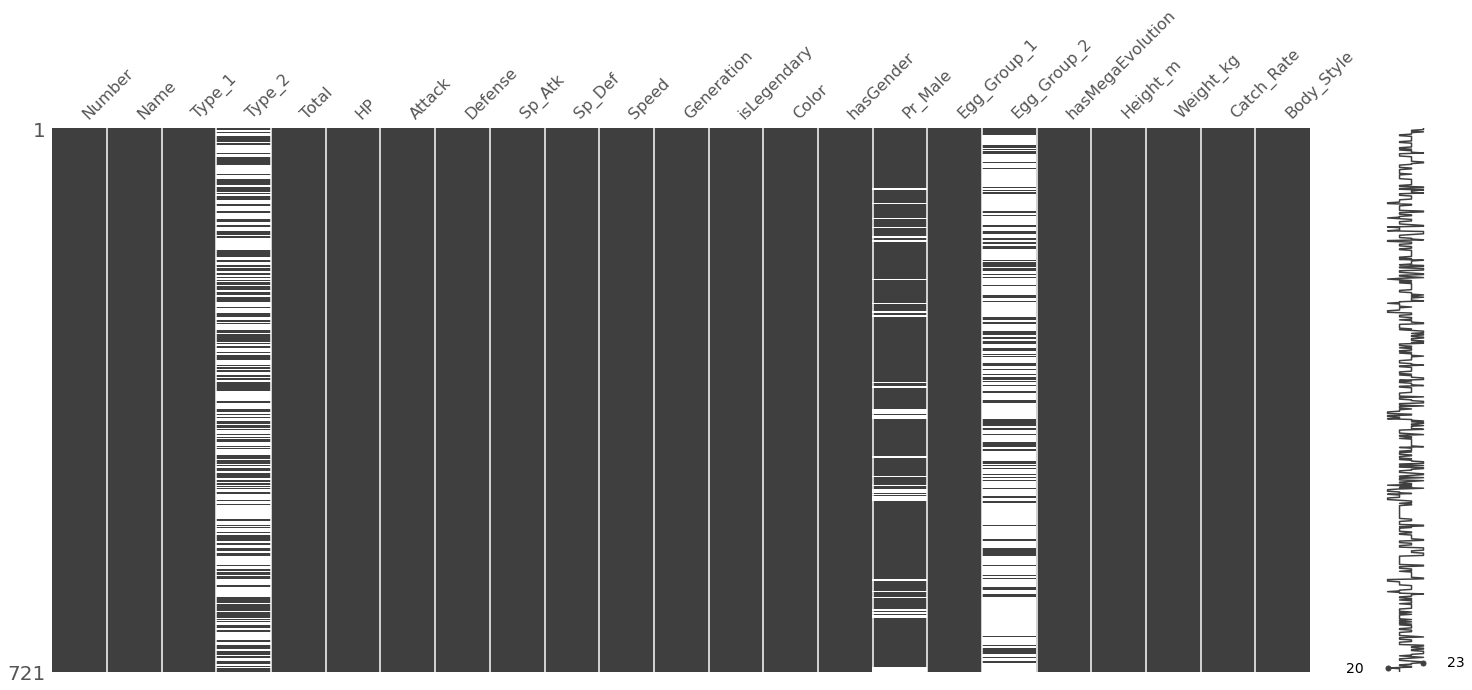

In [5]:
# here i used missingno matrix to see the distribution of null values columns
msno.matrix(pokemon)

* from above, Type_2 and Egg_Group_2 have relative null values

### 1.1.1 Type_1, Type_2

<AxesSubplot:>

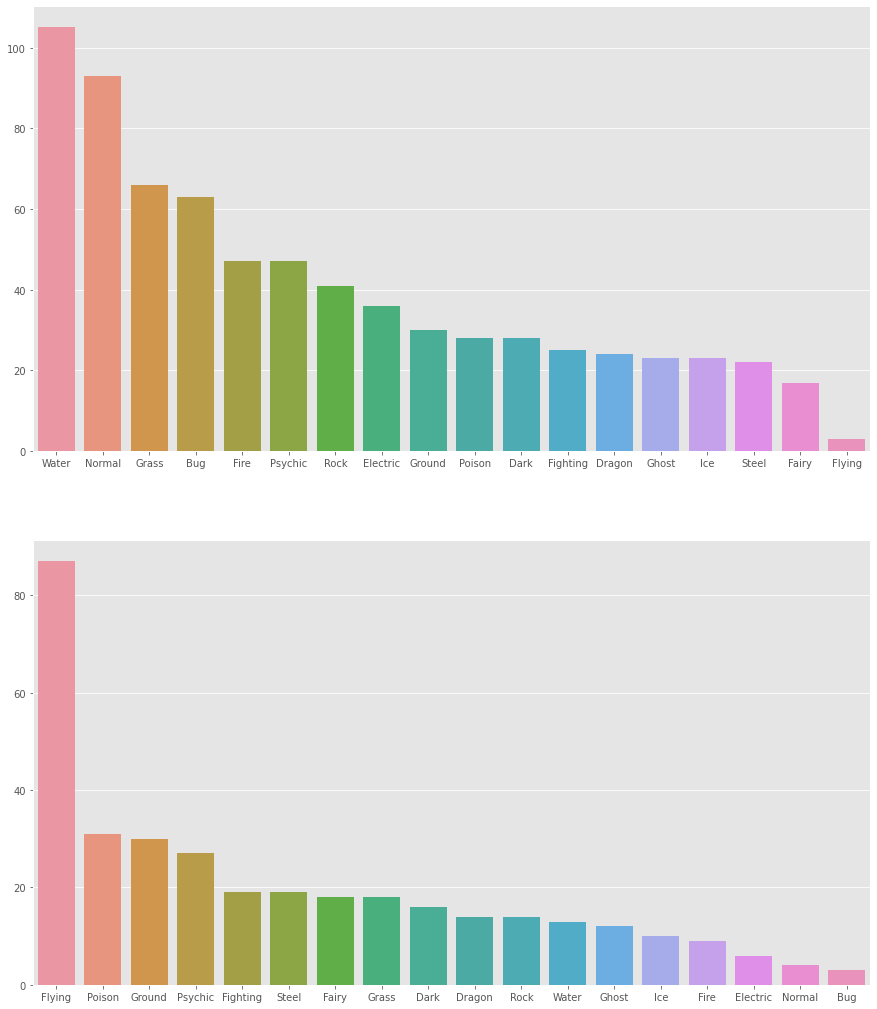

In [6]:
type1 = pokemon['Type_1'].value_counts()

type2 = pokemon['Type_2'].value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=2)

fig.set_size_inches(15,18)
# using seaborn barplot to visualize Type_1 and Type_2 
sns.barplot(x=type1.index,y=type1.values, ax= ax1)
sns.barplot(x=type2.index,y=type2.values, ax= ax2)

```
Type_2 almost consists of null vaues, so i decide to drop it later.
and from above, i can find that Type_1 has some correlate values(ex. water with ice),
and they'll be combined in feature engineering section.
```

### 1.1.2 Egg_Group_1, Egg_Group_2

<AxesSubplot:>

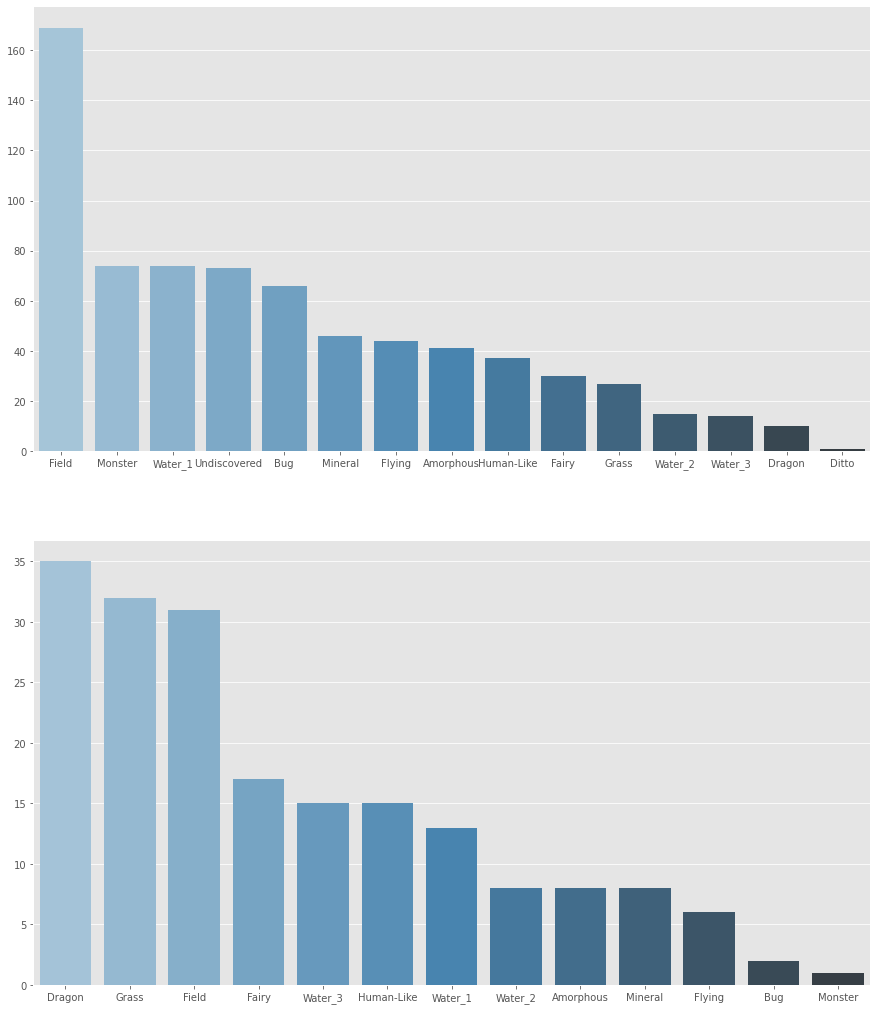

In [7]:
egg1 = pokemon['Egg_Group_1'].value_counts()

egg2 = pokemon['Egg_Group_2'].value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=2)

fig.set_size_inches(15,18)
# using seaborn barplot to visualize Type_1 and Type_2 
sns.barplot(x=egg1.index,y=egg1.values, palette="Blues_d", ax= ax1)
sns.barplot(x=egg2.index,y=egg2.values, palette="Blues_d",ax= ax2)

```
Egg_Group_2 also consists of lot null vaues, so it'll be droped.
and we can see that there're three Water columns above,
they'll be combined in feature engineering section.
```

### 1.1.3 Pr_Male

as Pr_Male column has few null values, so i decided to fill in it

<AxesSubplot:ylabel='Pr_Male'>

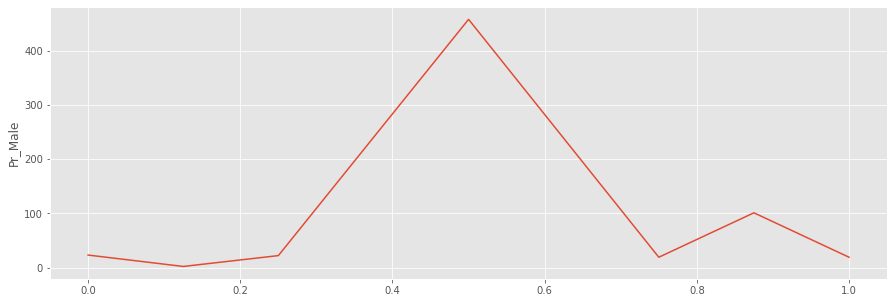

In [8]:
pokemon['Pr_Male'].value_counts()
plt.figure(figsize=(15,5))
sns.lineplot(data = pokemon['Pr_Male'].value_counts())

fill it with 0.500

In [9]:
pokemon['Pr_Male'].fillna(0.500, inplace=True)

let's drop two columns (Egg_Group_1, Type_2)

In [10]:
pokemon = pokemon.drop(['Type_2', 'Egg_Group_2'],axis=1)

now, see correlation between all columns below

<AxesSubplot:>

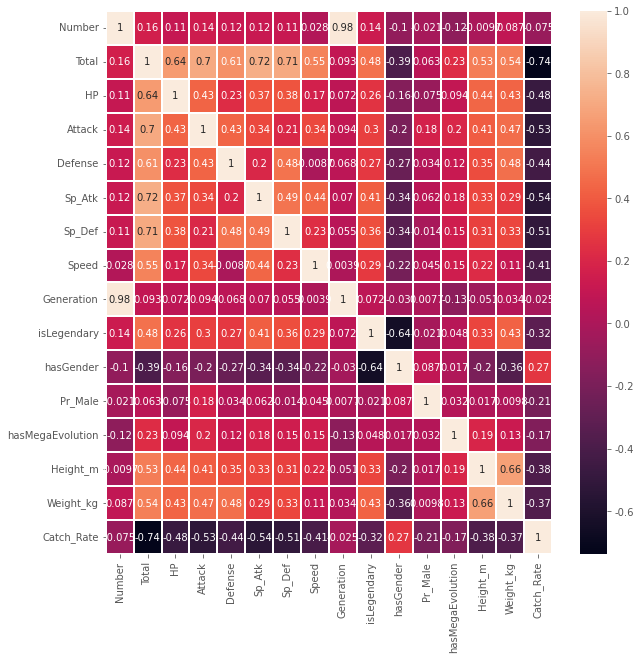

In [11]:
# # used heatmap here
# mask = np.array(pokemon.corr())
# mask[np.tril_indices_from(mask)] = False

plt.figure(figsize=(10,10))
# sns.heatmap(pokemon.corr(), annot=True,linewidths=.3)
sns.heatmap(pokemon.corr(), annot=True,linewidths=.3)

the lowest correlation is -0.64, so it seems not need to drop any columns.

and explore other columns:

### 1.1.4 Body_Style

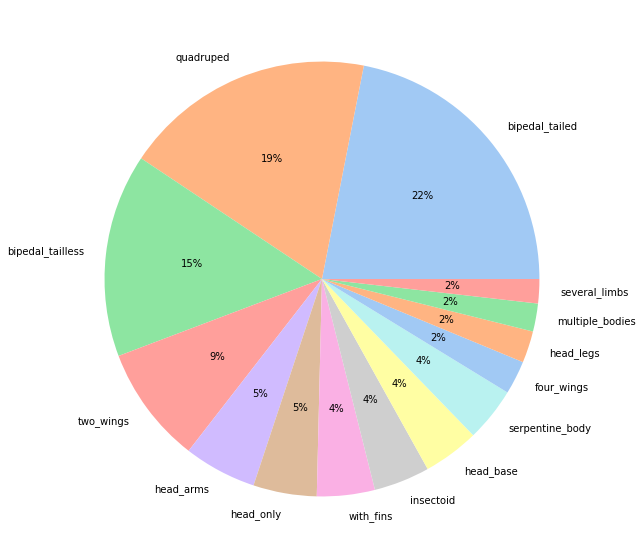

In [12]:
body_style = pokemon['Body_Style'].value_counts()

plt.figure(figsize=(15,10))
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(x = body_style.values, labels = body_style.index, colors = colors, autopct='%.0f%%')
plt.show()

bipedal_tailed is the most frequent body_style in the dataset(or in the pokemon world)

### 1.1.5 Color

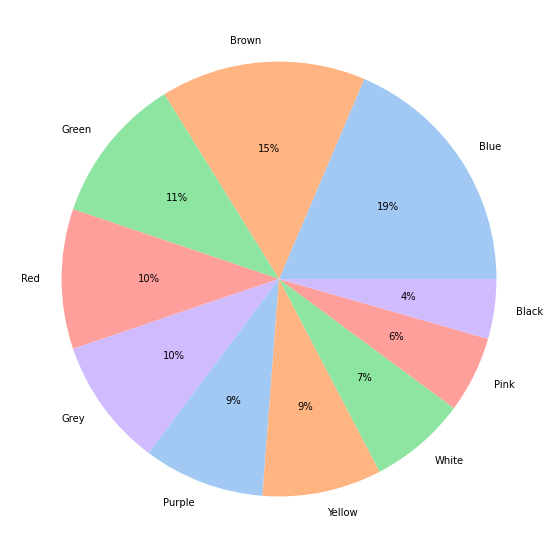

In [13]:
color = pokemon['Color'].value_counts()
plt.figure(figsize=(20,10))
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(x = color.values, labels = color.index, colors = colors, autopct='%.0f%%')
plt.show()

Blue -> Brown -> Green

### 1.1.6 has Mega Evoution

<AxesSubplot:>

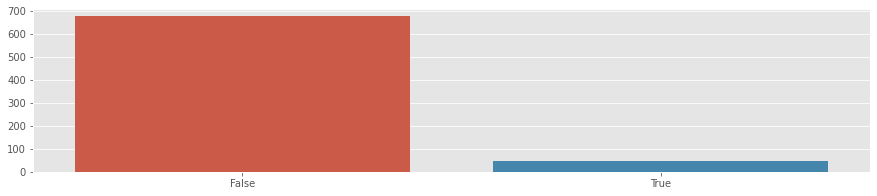

In [14]:
hasmega = pokemon['hasMegaEvolution'].value_counts()

plt.figure(figsize=(15,3))
sns.barplot(x=hasmega.index,y=hasmega.values)

most of pokemons doesn't have mega evolution

### 1.1.7 Body Style

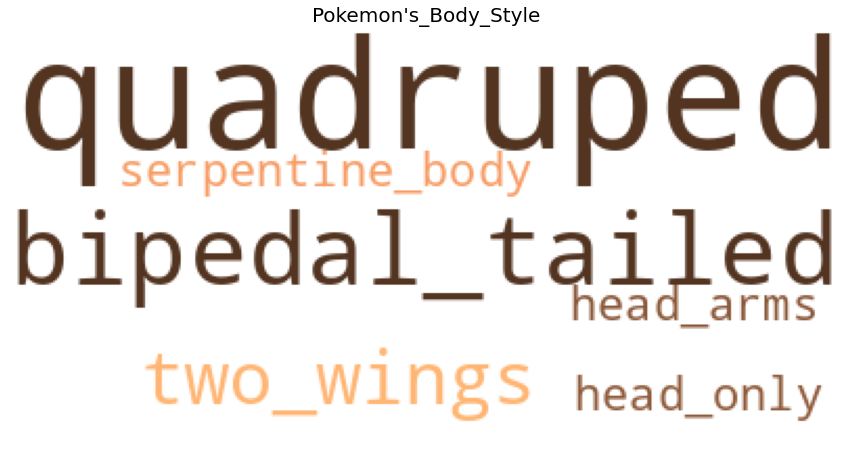

In [15]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (15,15))
stopwords = {'Length','dtype','Name','object','Body_Style'}
wordcloud = WordCloud(
                      background_color = 'white',
                      colormap="copper_r",
                      stopwords=stopwords,
                      max_words = 100,
                      max_font_size = 120,
                      random_state = 42
                    ).generate(str(pokemon['Body_Style']))

#Plotting the word cloud
plt.imshow(wordcloud)
plt.title("Pokemon's_Body_Style", fontsize = 20)
plt.axis('off')
plt.show()

In [16]:
pd.set_option('display.max_columns',None)

pokemon.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,309,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,False,1.09,19.0,45,bipedal_tailed


### 1.1.8 HP, Attack, Defense

[Text(0.5, 1.0, 'Defense')]

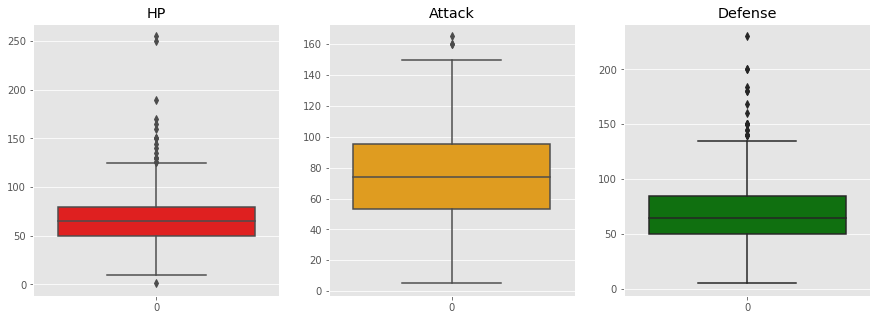

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(15,5)
sns.boxplot(data=pokemon.HP,ax=ax1,color='red').set(title='HP')
sns.boxplot(data=pokemon.Attack,ax=ax2,color='orange').set(title='Attack')
sns.boxplot(data=pokemon.Defense,ax=ax3,color='green').set(title='Defense')

### 1.1.9 Height, Weight_kg

In [18]:
pokemon['Height'] = pokemon['Height_m']*100

[Text(0.5, 1.0, 'Weight_kg')]

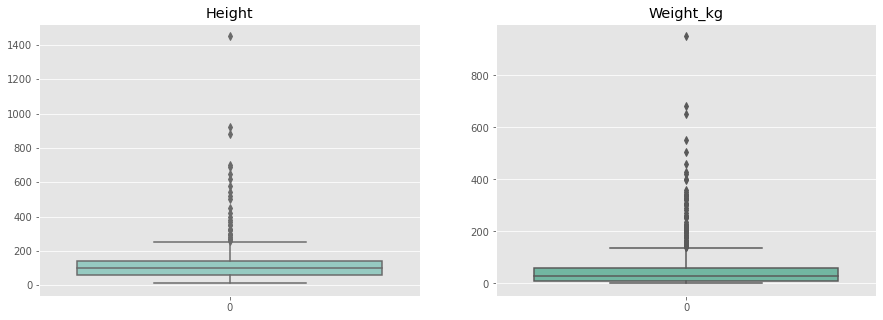

In [19]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
sns.boxplot(data=pokemon.Height,ax=ax1,palette="Set3").set(title='Height')
sns.boxplot(data=pokemon.Weight_kg,ax=ax2,palette="Set2").set(title='Weight_kg')

In [20]:
pokemon.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Height
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped,71.0
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,False,0.99,13.0,45,quadruped,99.0
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,True,2.01,100.0,45,quadruped,201.0
3,4,Charmander,Fire,309,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,False,0.61,8.5,45,bipedal_tailed,61.0
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,False,1.09,19.0,45,bipedal_tailed,109.0


In [21]:
legend_or_not = pd.get_dummies(pokemon["isLegendary"])
legend_or_not
Type1 = pokemon['Type_1']
# Type1 = pokemon['Type_1']
# print(type(Type1))
# df = pd.merge(Type1,legend_or_not)

## 2. feature engineering

here's feature engineering below:

In [22]:
# Type_1 and Egg_Group_1 
pokemon = pokemon.replace(['Water', 'Ice'],'Water_Ice')
pokemon = pokemon.replace(['Grass', 'Bug'],'Grass_Bug')
pokemon = pokemon.replace(['Ground', 'Rock'],'Ground_Rock')
pokemon = pokemon.replace(['Psychic','Dark','Ghost',"Fairy"],'Psychic_Dark_Ghost_Fairy')
pokemon = pokemon.replace(['Electric','Steel'],'ELectric_Steel')

pokemon = pokemon.replace(['Water_1','Water_2','Water_3'],'Water')

In [23]:
pokemon.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Height
0,1,Bulbasaur,Grass_Bug,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped,71.0
1,2,Ivysaur,Grass_Bug,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,False,0.99,13.0,45,quadruped,99.0
2,3,Venusaur,Grass_Bug,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,True,2.01,100.0,45,quadruped,201.0
3,4,Charmander,Fire,309,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,False,0.61,8.5,45,bipedal_tailed,61.0
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,False,1.09,19.0,45,bipedal_tailed,109.0


dummy variable below:

In [24]:
ref1 = dict(pokemon['Body_Style'].value_counts())

pokemon['Body_Style'] = pokemon['Body_Style'].map(ref1)

In [25]:
types_poke = pd.get_dummies(pokemon["Type_1"])
color_poke = pd.get_dummies(pokemon['Color'])

X = pd.concat([pokemon, types_poke],axis = 1)
X = pd.concat([X, color_poke], axis=1)

X.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Height,Dragon,ELectric_Steel,Fighting,Fire,Flying,Grass_Bug,Ground_Rock,Normal,Poison,Psychic_Dark_Ghost_Fairy,Water_Ice,Black,Blue,Brown,Green,Grey,Pink,Purple,Red,White,Yellow
0,1,Bulbasaur,Grass_Bug,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,False,0.71,6.9,45,135,71.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,Ivysaur,Grass_Bug,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,False,0.99,13.0,45,135,99.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,Venusaur,Grass_Bug,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,True,2.01,100.0,45,135,201.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,Charmander,Fire,309,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,False,0.61,8.5,45,158,61.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,False,1.09,19.0,45,158,109.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


and create X, y value used for predict legendary pokemon

In [26]:
y = pokemon.isLegendary
X = X.drop(['Number','Type_1',"Name",'Color','Egg_Group_1','isLegendary'],axis=1)

## 3.lightgbm

In [27]:
!pip install lightgbm

In [28]:
import lightgbm as lgb

split data using train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=116)

modeling:

In [30]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

parameters = {
    'task' : 'prediction',
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'auc',
    'verbosity':-1,
    'learning_rate':0.1,
    'reg_alpha':0,
    'reg_lambda':1
}

In [31]:
 model = lgb.train(
    parameters,
    train_set = lgb_train,
    valid_sets = lgb_eval,
)

[1]	valid_0's auc: 0.961716
[2]	valid_0's auc: 0.99703
[3]	valid_0's auc: 0.99571
[4]	valid_0's auc: 0.99571
[5]	valid_0's auc: 0.99571
[6]	valid_0's auc: 0.99571
[7]	valid_0's auc: 0.99571
[8]	valid_0's auc: 0.995545
[9]	valid_0's auc: 0.995545
[10]	valid_0's auc: 0.995545
[11]	valid_0's auc: 0.995545
[12]	valid_0's auc: 0.995545
[13]	valid_0's auc: 0.995545
[14]	valid_0's auc: 0.995545
[15]	valid_0's auc: 0.995545
[16]	valid_0's auc: 0.995545
[17]	valid_0's auc: 0.995545
[18]	valid_0's auc: 0.995545
[19]	valid_0's auc: 0.995545
[20]	valid_0's auc: 0.994884
[21]	valid_0's auc: 0.994884
[22]	valid_0's auc: 0.994884
[23]	valid_0's auc: 0.994884
[24]	valid_0's auc: 0.99637
[25]	valid_0's auc: 0.99637
[26]	valid_0's auc: 0.99637
[27]	valid_0's auc: 0.99637
[28]	valid_0's auc: 0.99604
[29]	valid_0's auc: 0.99604
[30]	valid_0's auc: 0.99604
[31]	valid_0's auc: 0.99604
[32]	valid_0's auc: 0.99604
[33]	valid_0's auc: 0.99604
[34]	valid_0's auc: 0.99604
[35]	valid_0's auc: 0.99604
[36]	valid_0

to be continued..